# Initialize

In [ ]:
!pip install numpy matplotlib scipy

## import

In [1]:
import sys
import os
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
from scipy import interpolate
from scipy.interpolate import interp1d

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

from QEdark_constants import *
from DM_halo_dist import *

## set directories

In [2]:
"""
set directories
"""
dataDir = os.getcwd()
FigDir = os.getcwd() + '/figs'

## plotting

In [4]:
# plotting specifications
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'cmr10'
#          'figure.autolayout': True
          }
plt.rcParams.update(params)
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['axes.labelsize']=16
plt.rcParams['figure.figsize']=(5,5)

cmap = plt.get_cmap("tab10") # default color cycle, call by using color=cmap(i) i=0 is blue
#reversed('RdBu')

# define useful functions

In [ ]:
rho_X = 0.4e9 # eV/cm^3
v0 = 230e5 # cm/s
vE = 240e5
vesc = 600e5

In [6]:
def vmin(EE,qin,mX):
    q = qin * alpha *me_eV
    return (EE/q+q/(2*mX))*c_light*1e-3 # to convert to km/s

Check the general behavior of $v_{\rm min}$

<ipython-input-6-b9aaa8779b05>:3: RuntimeWarning: divide by zero encountered in true_divide
  return (EE/q+q/(2*mX))*c_light*1e-3 # to convert to km/s
<ipython-input-6-b9aaa8779b05>:3: RuntimeWarning: invalid value encountered in true_divide
  return (EE/q+q/(2*mX))*c_light*1e-3 # to convert to km/s


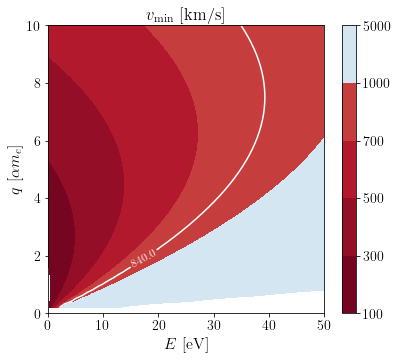

In [7]:
EE = np.linspace(0, 50, 50)
q = np.linspace(0, 10, 50)

alpha = 1/137.

X, Y = np.meshgrid(EE, q)
Z = vmin(X, Y,10e6)

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

vmax = [(vE+vesc)*1e-5]
levels = [100,300,500,700,1000,5000]
contour = plt.contour(X, Y, Z, vmax, colors = 'white')
plt.clabel(contour, colors = 'white', fmt = '%2.1f', fontsize=12)
contour_filled = plt.contourf(X, Y, Z, levels,cmap='RdBu')
plt.colorbar(contour_filled)

ax.set_title(r'$v_{\rm min}$ [km/s]')
ax.set_xlabel(r'$E$ [eV]')
ax.set_ylabel(r'$q~[\alpha m_e$]')
plt.show()
#fig.savefig(FigDir+'vmin.pdf',bbox_inches='tight')

## Load fcrystal and define rate/sigma functions

Load the crystal form-factors calculated by $\tt QEdark$. This requires the number of $q$-bins (nq) and the number of $E$-bins (nE); these numbers (nq, nE) are listed as the first row of $\it Si\_f2.txt$ and $\it Ge\_f2.txt$.

The dictionary $\tt materials$ contains the material specific information: $M_{\rm cell}, E_{\rm prefactor}, E_{\rm gap}, \epsilon$, and $f_{\rm crys}$. The first 4 parameters should be specified in units of eV. $E_{\rm prefactor}=2\pi^2(\alpha m_e^2 V_{\rm cell})^{-1}$, where $V_{\rm cell}$ is the volume of the unit cell. $f_{\rm crys}$ corresponds to $\frac{w_{\vec k}}{2}\frac{w_{\vec k}}{2}|f_{[i\vec k,i'\vec k',\vec G']}|^2$ in eq. (4.4) of arXiv:1509.01598. 

The functions defined are:
- ${\tt FDM(q_eV,n)}$: DM form factor
- ${\tt mu_Xe(mX)}$: DM-electron reduced mass, input is mX in eV
- ${\tt dRdE(material, mX, Ee, FDMn, halo, params)}$: differential scattering rate for sigma_e = 1 cm^2 at a fixed electron energy Ee given a DM mass, FDM, halo model; returns dR/dE [events/kg/year]
- ${\tt dRdne(material, mX, ne, FDMn, halo, params)}$: calculates rate for sigmae = 1 cm^2 in the ne bin, assuming fiducial values $\epsilon$ for binsize Si: 3.8 eV, Ge: 2.9 eV; returns dRdne [events/kg/year]
- ${\tt dRdnearray(material, mX, Ebin, FDMn, halo, params)}$: binlist [eV], dRdne [events/kg/year/Ebin]
- ${\tt sigmae(mXlist, material, nevents, exposure, ne, FDMn, halo, params)}$: cross-section assuming nevents (3 for bkgdfree), exposure is in kg-years, takes in array of mX in MeV; returns mX [MeV], sigma_e [cm^2]

In [8]:
dQ = .02*alpha*me_eV #eV
dE = 0.1 # eV
wk = 2/137

## import QEdark data
nq = 900
nE = 500

fcrys = {'Si': np.transpose(np.resize(np.loadtxt(dataDir+'/Si_f2.txt',skiprows=1),(nE,nq))),
         'Ge': np.transpose(np.resize(np.loadtxt(dataDir+'/Ge_f2.txt',skiprows=1),(nE,nq)))}

"""
    materials = {name: [Mcell #eV, Eprefactor, Egap #eV, epsilon #eV, fcrys]}
    N.B. If you generate your own fcrys from QEdark, please remove the factor of "wk/4" below. 
"""
materials = {'Si': [2*28.0855*amu2kg, 2.0, 1.2, 3.8,wk/4*fcrys['Si']], \
             'Ge': [2*72.64*amu2kg, 1.8, 0.7, 2.8,wk/4*fcrys['Ge']]}

def FDM(q_eV,n):
    """
    DM form factor
    n = 0: FDM=1, heavy mediator
    n = 1: FDM~1/q, electric dipole
    n = 2: FDM~1/q^2, light mediator
    """
    return (alpha*me_eV/q_eV)**n

def mu_Xe(mX):
    """
    DM-electron reduced mass
    """
    return mX*me_eV/(mX+me_eV)

def dRdE(material, mX, Ee, FDMn, halo, params):
    """
    differential scattering rate for sigma_e = 1 cm^2
    at a fixed electron energy Ee
    given a DM mass, FDM, halo model
    returns dR/dE [events/kg/year]
    """
    n = FDMn
    if Ee < materials[material][2]: # check if less than Egap
        return 0
    else:
        qunit = dQ
        Eunit = dE
        Mcell = materials[material][0]
        Eprefactor = materials[material][1]
        Ei = int(np.floor(Ee*10)) # eV
        prefactor = ccms**2*sec2year*rho_X/mX*1/Mcell*alpha*me_eV**2 / mu_Xe(mX)**2
        array_ = np.zeros(nq)
        for qi in range(1,nq+1):
            q = qi*qunit
            vmin = (q/(2*mX)+Ee/q)*ccms
            if vmin > (vesc+vE)*1.1: # rough estimate for kinematicaly allowed regions
                array_[qi-1] = 0
            else:
                """
                define halo model
                """
                if halo == 'shm':
                    eta = etaSHM(vmin,params) # (cm/s)^-1 
                elif halo == 'tsa':
                    eta = etaTsa(vmin,params)
                elif halo == 'dpl':
                    eta = etaDPL(vmin,params)
                elif halo == 'msw':
                    eta = etaMSW(vmin,params)
                elif halo == 'debris':
                    eta = etaDF(vmin,params)
                else:
                    print("Undefined halo parameter. Options are ['shm','tsa','dpl','msw','debris']")
                """
                define array
                """
                array_[qi-1] = Eprefactor*(1/q)*eta*FDM(q,n)**2*materials[material][4][qi-1, Ei-1]
        return prefactor*np.sum(array_, axis=0) # [(kg-year)^-1]

def dRdne(material, mX, ne, FDMn, halo, params):
    """
    calculates rate for sigmae = 1 cm^2 in the ne bin, 
    assuming fiducial values for binsize 
    Si: 3.8 eV, Ge: 2.9 eV
    return dRdne [events/kg/year]
    """
    Ebin = materials[material][3]
    ## check if ne is defined
    if ne*Ebin > dE*nE:
        print('$n_e$ is out of range, pick a smaller value')
        return 0
    elif ne == 0:
        print('$n_e$ must be > 0')
        return 0
    else:    
        tmpEbin = int(np.floor(Ebin/dE))+1
        tmpdRdE = np.zeros(tmpEbin)

        for i in range(tmpEbin):
            ## add up in bins of [1.2,4.9],[5,8.7],...
            tmpdRdE[i] = dRdE(material, mX, (ne-1)*Ebin+dE*i+materials[material][2], FDMn, halo, params)
        dRdne = np.sum(tmpdRdE, axis = 0)

        return dRdne
def dRdnearray(material, mX, Ebin, FDMn, halo, params):
    """
    calculates rate for sigmae = 1 cm^2, binned in Ebin, 
    return binlist [eV], dRdne [events/kg/year/Ebin]
    """    
    numbins = int(np.floor(nE*dE/Ebin))# calculate number of bins of size Ebin
    binlist = [materials[material][2]+ii*Ebin for ii in range(numbins)]
    tmpEbin = int(np.floor(Ebin/dE))
    tmpdRdE = np.zeros(tmpEbin)
    array_ = np.zeros(numbins)

    for ne in range(numbins-1):
        for i in range(tmpEbin):
            tmpdRdE[i] = dRdE(material, mX, ne*Ebin+dE*i+materials[material][2], FDMn, halo, params)
        array_[ne] = np.sum(tmpdRdE, axis = 0)
        
    return binlist, array_

def sigmae(mXlist, material, nevents, exposure, ne, FDMn, halo, params):
    """
    cross-section assuming nevents (3 for bkgdfree),
    exposure is in kg-years,
    takes in array of mX in MeV
    returns mX [MeV], sigma_e [cm^2]
    """
#    nevents = 3 # for bkgd free experiment
    sigmae = np.zeros(len(mXlist))
    for iimX in range(len(mXlist)):
        mX = mXlist[iimX]*1e6
        if dRdne(material, mX, ne, FDMn, halo, params) == 0:
            sigmae[iimX] = np.nan
        else:
            sigmae[iimX] = nevents/(dRdne(material, mX, ne, FDMn, halo, params)*exposure)
    return mXlist, sigmae

# Examples

## rate

In [65]:
%%time
"""
calculate the rate for fixed number of electrons (ne)
"""
mX = 1e7 # 10 MeV
ne = 1
nFDM = 0
elem = 'Si'
vhalo = 'shm'
vparams = [220e5,232e5,544e5] # cm/s
sigmae=1e-37 # cm2

sigmae*dRdne(elem,mX,ne,nFDM,vhalo,vparams)

CPU times: user 20.4 s, sys: 287 ms, total: 20.7 s
Wall time: 20.8 s


75276.69035540443

In [19]:
%%time
"""
calculate the rate vs ne for specified bin size
n.b. sigmae = 1
dRdneSHMfidarray is [Ee, dRdnearray]
"""
mX = 1e7 # 10 MeV
ne = 1
nFDM = 0
elem = 'Si'
binsize = 3.8 # eV
vhalo = 'shm'
vparams = [220e5,232e5,544e5] # cm/s

dRdneSHMfidarray=dRdnearray(elem,mX,binsize,nFDM,vhalo,vparams)

CPU times: user 1min 56s, sys: 1.54 s, total: 1min 58s
Wall time: 1min 58s


In [28]:
# print out Ee values
print('Ee values', dRdneSHMfidarray[0])
# print out Rate values
print('rate values: ',dRdneSHMfidarray[1])

Ee values [1.2, 5.0, 8.799999999999999, 12.599999999999998, 16.4, 20.2, 23.999999999999996, 27.799999999999997, 31.599999999999998, 35.4, 39.2, 43.0, 46.8]
rate values:  [7.19676414e+41 8.23344228e+41 1.47866615e+41 2.28231408e+40
 2.70902741e+39 3.59087636e+38 3.10451452e+37 1.55203833e+36
 5.53868701e+33 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


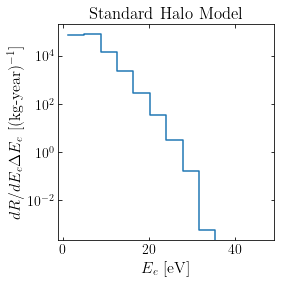

In [29]:
fig = plt.figure()
## definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.9, 0.6
sigmae=1e-37 # cm2

"""
create rate plot
"""
ff = interp1d(dRdneSHMfidarray[0],sigmae*dRdneSHMfidarray[1])
ax1 = fig.add_axes([left, bottom, width, height])
ax1.tick_params(direction='in',top=True, right=True)
ax1.step(dRdneSHMfidarray[0],sigmae*dRdneSHMfidarray[1],where='post')
#shmfid, = ax1.plot(dRdneSHMfidarray[0],sigmae*dRdneSHMfidarray[1],'o', color='black',label = 'SHM fiducial')
ax1.set_ylabel(r'$dR/dE_e\Delta E_e$ [(kg-year)$^{-1}$]')
#ax2.set_ylabel('rel. diff.')
ax1.set_title('Standard Halo Model')
ax1.set_yscale('log')
plt.xlabel(r'$E_e$ [eV]')

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

## cross-section

In [11]:
%%time

"""
define parameters
"""
vhalo = 'shm'
elem = 'Si'
FDMn = 0 # FDM=1
nevents = 3 # for background-free 
exposure = 1 # kg-year
mXlist = np.logspace(-1,3,30) # DM mass from 0.1 MeV to 1 GeV, 30 points in log-space
## SHM velocity parameters in cm/s [v0,vE,vesc]
shmfidparams = [220e5,232e5,544e5]
## ne = 1, 2 electrons
sigmaSHMfidne1 = sigmae(mXlist,elem,nevents,exposure,1,FDMn,vhalo,shmfidparams)
sigmaSHMfidne2 = sigmae(mXlist,elem,nevents,exposure,2,FDMn,vhalo,shmfidparams)

## save files to save time later
np.savetxt(dataDir+'/sigmaSHMfidne1.txt', sigmaSHMfidne1) 
np.savetxt(dataDir+'/sigmaSHMfidne2.txt', sigmaSHMfidne2) 

CPU times: user 15min 30s, sys: 12.5 s, total: 15min 43s
Wall time: 15min 48s


In [ ]:
# ## load files 
# sigmaSHMfidne1 = np.loadtxt(dataDir+'/sigmaSHMfidne1.txt').reshape(2, len(mXlist))
# sigmaSHMfidne2 = np.loadtxt(dataDir+'/sigmaSHMfidne2.txt').reshape(2, len(mXlist))

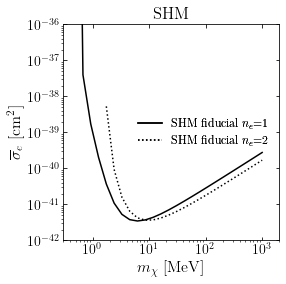

In [17]:
fig = plt.figure()
## definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.9, 0.6

"""
create cross-section plot
"""
ax1 = fig.add_axes([left, bottom, width, height],
                   xticklabels=[])
ax1.tick_params(direction='in',top=True, right=True)
shmline1, = ax1.plot(sigmaSHMfidne1[0],sigmaSHMfidne1[1], color='black',label = 'SHM fiducial $n_e$=1')
shmline2, = ax1.plot(sigmaSHMfidne2[0],sigmaSHMfidne2[1], color='black', linestyle = 'dotted',label = 'SHM fiducial $n_e$=2')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0.3, 2000)
ax1.set_ylim(1.0e-42, 1.0e-36)

first_legend = ax1.legend(handles=[shmline1,shmline2], loc = 'center right',frameon=False, fontsize=12)
## add legends
ax1.add_artist(first_legend)

ax1.set_ylabel(r'$\overline\sigma_e$ [cm$^2$]')
ax1.set_title('SHM')
plt.xlabel(r'$m_\chi$ [MeV]')

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()
#fig.savefig(FigDir+'sigmae_vs_mX.pdf',bbox_inches='tight')